<a href="https://colab.research.google.com/drive/16Nk0HRfcNhYx_uscGH7gU68mUxf7sjBB?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using google Colab for image clustering (With visualization)

This notebook contains information about image clustering. As a demo data set, we use Christmas Eve cards. Also, here describe the next topics:

- How to quickly create a data set of images. What tools exist for uploading a large number of relevant images;

- Preparation of images for machine learning;

- Image clustering

- Data sampling

- Transferring data into 2-dimensional space

- Visualization

In [ ]:
!pip install fastai==1.0.58

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 236 kB 30.1 MB/s 
     |████████████████████████████████| 355 kB 57.8 MB/s 
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=cf9ce179d6135b8bc7c1c3240638be455eac75cdffe3fd1ca82a4325483be546
  Stored in directory: /root/.cache/pip/wheels/df/99/da/c34f202dc8fd1dffd35e0ecf1a7d7f8374ca05fbcbaf974b83
Successfully built nvidia-ml-py3
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9


In [ ]:
from bs4 import BeautifulSoup
from fastprogress import progress_bar
from time import sleep

import pandas as pd, requests, numpy as np # For matrix math

%matplotlib inline

## Create a data set of images

### Browser extension

Download Firefox/Chrome extension
https://addons.mozilla.org/en-US/firefox/addon/ia-batch-image-downloader/

On the image [search page](https://images.google.com/), enter the appropriate search query. On the search results page, click on the extension icon and choose to download the images.

### Flickr

Another option to download many images for a search query is to scrape Flickr
We can use Simple [Flickr Image Scraper](https://github.com/ultralytics/flickr_scraper)

**Instalation**

Clone the project

`git clone https://github.com/ultralytics/flickr_scraper`

Open folder

`cd flickr_scraper`

Installing Packages 

`pip install -U -r requirements.txt`

- Request a Flickr API key: https://www.flickr.com/services/apps/create/apply
[API doc](https://www.flickr.com/services/developer/api/)

- Write your API key and secret in flickr_scraper.py L11-L12:

```
key = ''
secret = ''
```

**Run**

Search for up to `n` images, and optionally `--download`. URLs are printed to screen and downloaded images are saved in `flickr_scraper/images`. Note that image downloads may be subject to Flickr rate limits and other limitations. See https://www.flickr.com/services/developer/api/ for full information.

`python3 flickr_scraper.py --search 'honeybees on flowers' --n 10 --download`




## Image clustering

In [ ]:
from fastai.vision import *
from pathlib import Path

path = Path('.')

Next commands create `img` folder, and then we download our Christmas Eve cards and unzip it. You can replace data set with your images

In [ ]:
!mkdir img && cd img && mkdir img && cd img && wget https://gitlab.com/balexey/clb/-/raw/main/imgc.zip && unzip imgc.zip && rm imgc.zip

--2022-11-06 19:16:47--  https://gitlab.com/balexey/clb/-/raw/main/imgc.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66955776 (64M) [application/octet-stream]
Saving to: ‘imgc.zip’

imgc.zip            100%[===================>]  63.85M  38.8MB/s    in 1.6s    

2022-11-06 19:16:49 (38.8 MB/s) - ‘imgc.zip’ saved [66955776/66955776]

Archive:  imgc.zip
   creating: imgc/
  inflating: __MACOSX/._imgc         
  inflating: imgc/happy-christmas-christmas-card-pack-of-10-01_400x.jpg  
  inflating: __MACOSX/imgc/._happy-christmas-christmas-card-pack-of-10-01_400x.jpg  
  inflating: imgc/christmas-snowman.png  
  inflating: __MACOSX/imgc/._christmas-snowman.png  
  inflating: imgc/4c92ffd8316ce84bb8a6ad018d015fdc-247-15834.jpeg  
  inflating: __MACOSX/imgc/._4c92ffd8316ce84bb8a6ad018d015fdc-247-15834.jpeg  
  inflating: img

In [ ]:
! ls img/img/imgc | wc -l

229


The NVIDIA System Management Interface (nvidia-smi) is a command line utility.This utility allows administrators to query GPU device state and with the appropriate privileges, permits administrators to modify GPU device state.

In [ ]:
!nvidia-smi

Sun Nov  6 19:17:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

- `warnings.filterwarnings("ignore")` suppress a third-party warning. 

- Functions `torch.cuda.empty_cache()` releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi.відеокарти

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def clear():
    gc.collect(); torch.cuda.empty_cache()

We use `ImageDataBunch` from fastai. Note: This feature is not available in newer versions

In [ ]:
data = ImageDataBunch.from_folder(path,
                                  train='./', test='./',
                                  valid_pct=0,
                                  size=256,
                                  bs=48)

In [ ]:
learn = cnn_learner(data, models.resnet101)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

We set everything up to train a model that classifies images. Next, we will use [Reznet101](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html). Reznet101 is a large trained model that can distinguish many classes and classify images into 1000 object categories.
Models have many layers. The last layer is responsible for our task, and the previous layers generalize the knowledge about shapes, lines, colors, and patterns obtained during training on a large amount of data.

The penultimate layer of the model outputs N numbers that contain generalized information about the image, a kind of image vector code. We need to get this last layer.

In [ ]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=1, bias=True)
)

We saw the model's head. These are several pooling of previous layers and linear layers with normalizations. Linear layers will then learn to make predictions based on the transformations of the backbone of the model.

In [ ]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


A bunch of trained convolutional layers that can work with different types of images and can be trained just a little bit on your data. We, in turn, get a distributed representation of each image from this model.

In [ ]:
test = next(iter(learn.dl(DatasetType.Test)))
test

[tensor([[[[0.2873, 0.3199, 0.3488,  ..., 0.5268, 0.5188, 0.5127],
           [0.2996, 0.3160, 0.3821,  ..., 0.5102, 0.5262, 0.5360],
           [0.2953, 0.3198, 0.3649,  ..., 0.5091, 0.5329, 0.5243],
           ...,
           [0.8902, 0.8902, 0.8918,  ..., 0.9038, 0.8967, 0.9080],
           [0.8902, 0.8902, 0.8902,  ..., 0.9022, 0.8954, 0.8966],
           [0.8902, 0.8902, 0.8902,  ..., 0.9041, 0.8961, 0.8902]],
 
          [[0.3206, 0.3552, 0.3880,  ..., 0.5522, 0.5462, 0.5402],
           [0.3329, 0.3513, 0.4213,  ..., 0.5356, 0.5536, 0.5634],
           [0.3287, 0.3554, 0.4041,  ..., 0.5355, 0.5603, 0.5502],
           ...,
           [0.8941, 0.8941, 0.8957,  ..., 0.9077, 0.9005, 0.9118],
           [0.8941, 0.8941, 0.8941,  ..., 0.9060, 0.9032, 0.9045],
           [0.8941, 0.8941, 0.8941,  ..., 0.9079, 0.9040, 0.8980]],
 
          [[0.2578, 0.2806, 0.2918,  ..., 0.4189, 0.4168, 0.4186],
           [0.2702, 0.2767, 0.3252,  ..., 0.4023, 0.4242, 0.4418],
           [0.2659, 0.27

This is one batch of our data. Has the image itself normalized and of a standardized size. As well as labels that we do not need, we made them so that fastai would not give an error

In [ ]:
learn.freeze()
learn.model.eval();

In [ ]:
clear()

In [ ]:
with torch.no_grad():
    out_test = learn.model[0](test[0])
    print(out_test[:2], out_test.shape)

tensor([[[[0.0169, 0.0000, 0.0000,  ..., 0.0000, 0.1005, 0.1993],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1751, 0.0483],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.4233, 0.1804],
          ...,
          [0.0000, 0.2595, 1.4481,  ..., 1.0855, 1.1603, 0.7968],
          [0.0000, 0.0000, 1.0761,  ..., 0.3348, 0.5843, 0.3484],
          [0.0000, 0.0318, 0.6755,  ..., 0.4197, 0.0879, 0.0220]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.1530, 0.2975, 0.2109],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0190],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2550],
          [0.0000, 0.1194, 0.3781,  ..., 0.0000, 0.0000, 0.0166],
          [0.7707, 0.5418, 1.7039,  ..., 0

In [ ]:
with torch.no_grad():
    out_test2 = learn.model[1][:2](out_test)
    print(out_test2.shape)

torch.Size([48, 4096])


In [ ]:
pd.DataFrame(out_test2.cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.448097,0.297464,2.428061,0.839866,1.106982,0.189083,0.916356,0.956928,4.045601,0.977397,...,0.379755,0.307208,0.195652,0.320042,0.401967,0.130044,0.740841,1.669573,0.249086,0.084621
1,2.254733,0.498948,2.598441,2.886291,1.275495,1.533372,1.630597,2.020247,3.366811,0.846182,...,1.104464,0.657898,0.146535,0.190044,0.805928,0.150109,0.317471,1.853745,0.226701,0.094715
2,2.091432,2.782382,3.232022,2.310219,1.164135,5.308666,1.410352,1.450066,2.415213,1.813985,...,0.230274,0.248890,1.064339,0.334715,0.383893,0.558461,0.721744,1.638083,0.331675,0.159655
3,0.754745,0.924468,3.628682,3.801335,1.708481,1.819766,1.630163,2.136244,1.168313,0.440954,...,1.873080,0.728370,0.007309,0.160858,0.038100,0.170443,0.770805,2.294020,0.016675,0.024462
4,1.705901,0.354932,2.420171,5.789006,1.690559,1.278426,0.634467,3.879682,0.894739,0.400953,...,0.933557,0.143546,0.806823,0.153889,0.574006,0.217380,0.553153,1.102826,0.100870,0.025898
5,0.517039,1.485834,2.005781,3.340878,1.367463,0.254395,1.233796,2.853229,3.439390,2.712507,...,1.439684,0.634715,0.432327,0.757224,0.820646,0.046280,1.393608,1.131660,0.476953,0.134080
6,4.359567,0.492672,1.669715,5.561769,0.777053,1.463884,0.838104,2.390796,1.243895,0.140309,...,1.905354,0.016168,0.014134,0.306592,0.230803,0.268345,0.171403,0.962448,0.256434,0.021794
7,2.433656,1.659835,3.697438,2.967074,4.666082,1.386905,1.660557,2.084576,1.287225,0.681788,...,0.380644,0.030598,0.308991,0.512380,0.440329,1.285245,1.931379,1.153500,0.885448,0.024490
8,3.628625,1.277927,3.584340,2.547189,0.743881,0.807784,0.996269,2.789990,4.419222,0.732677,...,0.648732,0.864388,0.052258,1.225964,0.942765,0.073749,0.554092,3.127107,1.203244,0.008091
9,0.823786,0.331029,4.691996,3.782107,0.854500,0.232696,1.030921,4.399460,1.352425,0.756793,...,1.536691,0.583363,0.077007,0.538661,0.462982,0.123253,1.101108,2.867030,0.173934,0.035690


A large model gives a result of the form batch\*2048\*6\*6.
This is what the neural network layers produce in the end. Then, this result compares the average and maximum values of 3 and 4 dimensions. This gives the final form of batch\*4096. A vector represents each image in the batch with a size of 4096.

### A function that will get the distributed views for each image:

In [ ]:
def get_img_vector(batch):
    x = batch[0]    # бетч це 64 матриці зображень та лейблів
    # 1) "велика" модель обробляє x
    img_vector = learn.model[0](x)
    # 2) пулимо і сплющуємо результат
    img_vector = learn.model[1][:2](img_vector) 
    # 3) з torch торч назад у np.ndarray 
    return img_vector.cpu().numpy()

In [ ]:
clear()

In [ ]:
with torch.no_grad():
    vectors = [
        get_img_vector(b)
        for b in progress_bar(data.test_dl)
    ]

In [ ]:
vectors[0]

array([[1.448097, 0.297464, 2.428061, 0.839866, ..., 0.740841, 1.669573, 0.249086, 0.084621],
       [2.254733, 0.498948, 2.598441, 2.886291, ..., 0.317471, 1.853745, 0.226701, 0.094715],
       [2.091432, 2.782382, 3.232022, 2.310219, ..., 0.721744, 1.638083, 0.331675, 0.159655],
       [0.754745, 0.924468, 3.628682, 3.801335, ..., 0.770805, 2.29402 , 0.016675, 0.024462],
       ...,
       [3.384881, 1.946029, 4.534088, 1.344258, ..., 0.153387, 1.128866, 0.329726, 0.03294 ],
       [2.104784, 0.687616, 2.466799, 2.264575, ..., 0.123547, 0.601678, 0.099762, 0.076071],
       [0.405465, 0.      , 2.482521, 5.069809, ..., 0.346529, 1.190314, 0.      , 0.045269],
       [1.971198, 0.303779, 2.651237, 2.463993, ..., 0.717652, 2.02513 , 0.100473, 0.024212]], dtype=float32)

In [ ]:
vectors = np.vstack(vectors)

Dataloader by fastai shuffles images. Therefore, we need to associate our pictures with their names

In [ ]:
sampler = [i for i in learn.dl(DatasetType.Test).sampler]
# Order Normalization
result = vectors[np.argsort(sampler)]

In [ ]:
result = pd.DataFrame(result)
result

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.448097,0.297464,2.428061,0.839866,1.106982,0.189083,0.916356,0.956928,4.045601,0.977397,...,0.379755,0.307208,0.195652,0.320042,0.401967,0.130044,0.740841,1.669573,0.249086,0.084621
1,2.254733,0.498948,2.598441,2.886291,1.275495,1.533372,1.630597,2.020247,3.366811,0.846182,...,1.104464,0.657898,0.146535,0.190044,0.805928,0.150109,0.317471,1.853745,0.226701,0.094715
2,2.091432,2.782382,3.232022,2.310219,1.164135,5.308666,1.410352,1.450066,2.415213,1.813985,...,0.230274,0.248890,1.064339,0.334715,0.383893,0.558461,0.721744,1.638083,0.331675,0.159655
3,0.754745,0.924468,3.628682,3.801335,1.708481,1.819766,1.630163,2.136244,1.168313,0.440954,...,1.873080,0.728370,0.007309,0.160858,0.038100,0.170443,0.770805,2.294020,0.016675,0.024462
4,1.705901,0.354932,2.420171,5.789006,1.690559,1.278426,0.634467,3.879682,0.894739,0.400953,...,0.933557,0.143546,0.806823,0.153889,0.574006,0.217380,0.553153,1.102826,0.100870,0.025898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,1.133272,0.000000,2.650308,2.281096,2.188567,0.170070,0.997618,1.509620,0.000000,2.287756,...,0.810768,0.397111,0.095128,0.033080,0.533592,0.371833,0.325041,0.717391,0.022302,0.035332
225,1.949041,4.258772,3.158999,5.453829,1.201959,0.244640,1.853508,2.136127,3.418600,3.267465,...,0.367687,0.104481,0.334014,0.167073,0.330598,0.617320,0.297276,0.375572,1.772068,0.102941
226,1.421323,2.477570,3.280323,3.552837,0.995640,3.880383,0.762564,4.084711,0.653913,2.666391,...,0.461924,0.537094,0.222486,0.308749,0.561513,0.391435,1.692474,1.804622,0.926591,0.057408
227,1.397837,0.254475,2.063245,4.238362,1.747696,0.050036,1.122135,2.597722,1.457095,0.669511,...,1.320970,0.969184,0.757243,0.367649,0.196129,0.030681,0.411672,2.161090,0.345731,0.045494


### Data sampling
It won't be easy to visualize everything. We will make a sample for the prototype.

In [ ]:
files_df = pd.DataFrame(data.test_ds.items, columns=['name'])

In [ ]:
files_df = pd.DataFrame(data.test_ds.items, columns=['name'])
result.to_csv('christmascсard.tsv', sep='\t',
              header=False, index=False)

files_df.to_csv('christmas_card.csv', index=False)

In [ ]:
result_sample = result.sample(200)

In [ ]:
result_sample.to_csv('christmas_card_sample_resnet101.tsv', sep='\t',
              header=False, index=False)

files_df.reindex(result_sample.index
       ).to_csv('christmas_sample_filenames.csv', index=False)

In [ ]:
len(files_df)

229

In [ ]:
result_sample.shape

(200, 4096)

## Transferring data into 2-dimensional space

Once we have uploaded our images as vectors, we can choose from many models and features to analyze them further.
  
For example, using two different algorithms, let's try to visualize all our postcards in 2-dimensional space.

### TSNE

In [ ]:
result_sample = pd.read_csv('christmas_card_sample_resnet101.tsv', sep='\t', header=None)
files_df = pd.read_csv('christmas_sample_filenames.csv')

In [ ]:
from sklearn.manifold import TSNE
result_sample.head(3)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,1.054923,0.026858,4.230317,2.325212,0.485015,0.000000,0.835566,4.039100,0.838812,0.406740,...,0.614091,0.119654,0.527599,0.491952,0.380271,0.002643,1.516963,1.815431,0.058832,0.000298
1,2.104784,0.687616,2.466800,2.264575,1.795754,2.035389,2.017834,2.541975,2.066810,1.407472,...,0.448622,0.141319,0.559256,0.321622,0.314454,0.100390,0.123547,0.601678,0.099762,0.076071
2,2.986747,0.088304,1.978165,2.053378,1.802651,0.841358,2.818304,1.846510,0.374906,2.807905,...,0.986893,0.100142,0.417376,0.382030,0.735083,0.060553,1.169123,1.270261,0.524907,0.000885


In [ ]:
X_embedded_tsne = TSNE(n_components=2).fit_transform(result_sample)
X_embedded_tsne.shape

(200, 2)

In [ ]:
# standardize
X_embedded_tsne -= X_embedded_tsne.min(axis=0)
X_embedded_tsne /= X_embedded_tsne.max(axis=0)

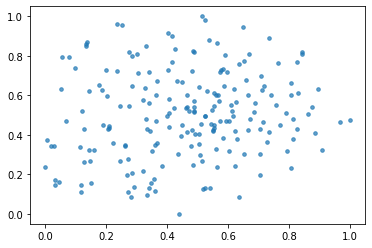

In [ ]:
# visualize our postcard data cloud

plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], alpha=0.7, s=13)
plt.show()

## UMAP

[UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) is a general purpose manifold learning and dimension reduction algorithm.


In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.9 MB/s 
     |████████████████████████████████| 1.1 MB 27.5 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=1e0640612013dc99e210a591159244a3c1997a053a80a99d728dc74af4adceb3
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=22d99fb63d4831d1b48b47e8a107501bb80592b292ceac11907a9308755b3b4c
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
X_embedded = reducer.fit_transform(result_sample)
X_embedded.shape

(200, 2)

In [ ]:
# standardize

X_embedded -= X_embedded.min(axis=0)
X_embedded /= X_embedded.max(axis=0)

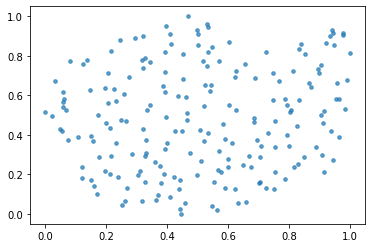

In [ ]:
# visualize our data 

plt.scatter(X_embedded[:,0], X_embedded[:,1], alpha=0.7, s=13)
plt.show()

## Visualization

Let's display the image of the postcards on the graph to evaluate our algorithm.

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.pyplot import savefig
from skimage.transform import resize
plt.rcParams['figure.figsize'] = (22, 14)

In [ ]:
img_paths = (files_df.reindex(result_sample.index)
             .name
             .astype(str)
             .values
             .tolist()
             )

x = X_embedded[:,0]
y = X_embedded[:,1]

img_shape = [plt.imread(x).shape[0:2] for x in img_paths]

Rescale

The main problem with this type of visualization is the different sizes of the images. For uniformity, reduce the width to 100 and proportionally change the height of each image.

About resize [here](https://scikit-image.org/docs/stable/auto_examples/transform/plot_rescale.html#sphx-glr-auto-examples-transform-plot-rescale-py )


In [ ]:
# let's create a python list with a new height value for each image 
h_new = [round((x[1]/x[0])* 100) for x in img_shape]

def getImage(path, h):
    
    # resize function from skimage.transform
    image = resize(plt.imread(path), (100, h))
    
    # Calibrate zoom if needed 
    return OffsetImage(image, zoom=.5)


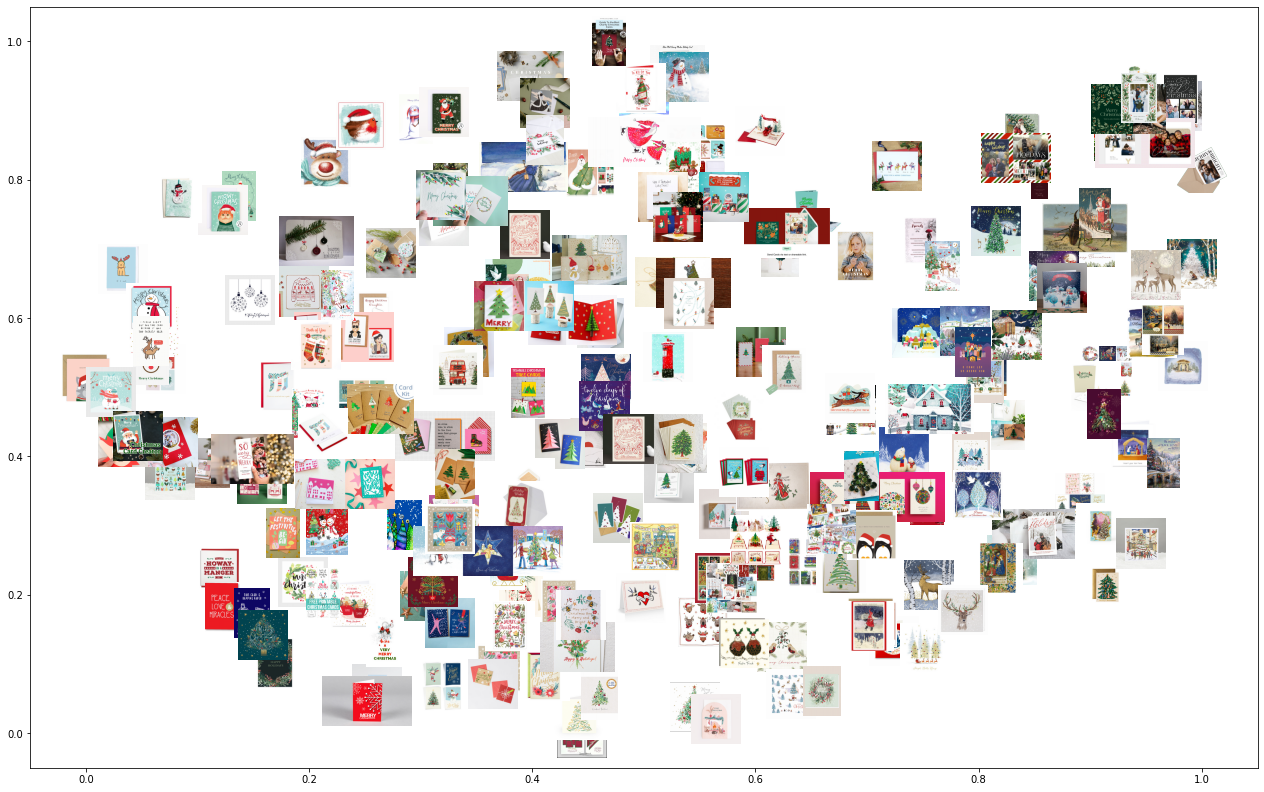

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x, y) 

for x0, y0, path, h in zip(x, y, img_paths, h_new):
    ab = AnnotationBbox(getImage(path, h), (x0, y0), frameon=False)
    ax.add_artist(ab)

# savefig('plot.png')    